# From trained model to HW using the finn compiler

We will go through network preparation and conversion

In [16]:
# get onnx model from last LAB
filename = "/tmp/finn_dev_rootmin/ready_finn.onnx"

In [ ]:
from finn.util.visualization import showSrc, showInNetron
showInNetron(filename)

## Network preparing for finn

- Tidy up (and also after EACH step)
- Pre (data feed) / Post proc (top k)
- Model streamlining
- Model Preparation (merge into HLS convertibles)
- Model HW Layers
- Model data flow partitions
- Specialize layer, ready for hw conversion (hls)

In [18]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.core.modelwrapper import ModelWrapper

model = ModelWrapper(filename)

# TIDY UP
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save("/tmp/finn_dev_rootmin/tidy.onnx")

In [ ]:
showInNetron("/tmp/finn_dev_rootmin/tidy.onnx")

### Pre processing

In Brevitas, our model was trained on FP32 data ranging from 0 to 1 as this is how PyTorch works.

The problem is FINN model will only use 0 to 255 INT8 input once in hgardware, [or at least it will assume integer input](https://github.com/Xilinx/finn/issues/1174#issuecomment-2331778330)

As we will feed 8 bit raw data to the FINN model as required, we can bake in the graph a transfosrmation to divide by 255 to feed 0 to 1 values to the rest of the moidel (as we did in training)

In [ ]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import torch
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

# PRE PROC : NONE
model = ModelWrapper("/tmp/finn_dev_rootmin/tidy.onnx")

"""
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
export_qonnx(totensor_pyt, torch.randn(ishape), "/tmp/finn_dev_rootmin/preproc.onnx")
qonnx_cleanup("/tmp/finn_dev_rootmin/preproc.onnx", out_file="/tmp/finn_dev_rootmin/preproc.onnx")
pre_model = ModelWrapper("/tmp/finn_dev_rootmin/preproc.onnx")
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])
"""


model.save("/tmp/finn_dev_rootmin/full_preproc.onnx")
showInNetron("/tmp/finn_dev_rootmin/full_preproc.onnx")

## TEST THE NEW MODEL

With this new "adapter" layer, we might have to check if the model is still working !

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

model = ModelWrapper("/tmp/finn_dev_rootmin/full_preproc.onnx")

# get some INT 8 data by quantizing some FashionMNIST data
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
);

# Check how it looks (looks good, nice)
print("Quick check on data...")
print(torch.min(test_dataset_qnt[0][0]))
print(torch.max(test_dataset_qnt[0][0]))
print(test_dataset_qnt[0][0].dtype)

test_loader_qnt = DataLoader(test_dataset_qnt, 100)

# RUN INFERENCE
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe

# test the model
correct = 0
total = 0
loss_total = 0
print("\\nRunning the testing loop with ONNX model inference !\n")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader_qnt):
        images = torch.reshape(images, (100, 28*28))
        for image_idx, image in enumerate(images):
            input_tensor = image.detach().numpy().reshape(1, 28 * 28)
            # print(input_tensor)
            input_dict = {"global_in": input_tensor}
            output_dict = oxe.execute_onnx(model, input_dict)
            produced_qonnx = output_dict[list(output_dict.keys())[0]]
            _, predicted = torch.max(torch.from_numpy(produced_qonnx).data, 1)
            total += 1
            correct += predicted.item() == labels[image_idx].item()
            if image_idx % 10 == 0 : print(image_idx, "done !")
        print(batch_idx, "done !")
        if batch_idx == 0 : break # just do 1 batch, too long !

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

In [ ]:
from qonnx.transformation.insert_topk import InsertTopK

# POST PROC

# insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = "/tmp/finn_dev_rootmin/pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(chkpt_name)

In [ ]:
from finn.transformation.streamline import Streamline
# we can see the list of apllied transformations here : showSrc(Streamline)
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper("/tmp/finn_dev_rootmin/pre_post.onnx")
# STREAMLINE
model = model.transform(Streamline())
model.save("/tmp/finn_dev_rootmin/streamlined.onnx")
showInNetron("/tmp/finn_dev_rootmin/streamlined.onnx")

In [ ]:
# MODEL PREP

from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = ModelWrapper("/tmp/finn_dev_rootmin/streamlined.onnx")

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")
showInNetron("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")

In [ ]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw

# TO HW LAYERS

model = ModelWrapper("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")
model = model.transform(to_hw.InferLabelSelectLayer())
model = model.transform(to_hw.InferChannelwiseLinearLayer())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
model = model.transform(to_hw.InferThresholdingLayer())
model.save("/tmp/finn_dev_rootmin/hw.onnx")
showInNetron("/tmp/finn_dev_rootmin/hw.onnx")

In [ ]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper("/tmp/finn_dev_rootmin/hw.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save("/tmp/finn_dev_rootmin/df_part.onnx")
showInNetron("/tmp/finn_dev_rootmin/df_part.onnx")

In [ ]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)

In [ ]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

In [29]:
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 20

In [ ]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = ModelWrapper(dataflow_model_filename)

model = model.transform(SpecializeLayers(fpga_part))

model.save("/tmp/finn_dev_rootmin/to_hw_conv.onnx")
showInNetron("/tmp/finn_dev_rootmin/to_hw_conv.onnx")

# HARDWARE BUILD

In [ ]:
# ESTIMATE
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "/tmp/finn_dev_rootmin/to_hw_conv.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

build.build_dataflow_cfg(model_file, cfg_estimates)

In [ ]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

In [ ]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

In [ ]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

In [ ]:
# Actual hardware build, ZYNQ BUILD
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

model = ModelWrapper("/tmp/finn_dev_rootmin/to_hw_conv.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns,partition_model_dir="./test",enable_debug=True))

In [36]:
model.save("/tmp/finn_dev_rootmin/post_synth.onnx")

In [ ]:
showInNetron("/tmp/finn_dev_rootmin/post_synth.onnx")

In [38]:
model = ModelWrapper("/tmp/finn_dev_rootmin/post_synth.onnx")

In [ ]:
model.model.metadata_props
# en fouillant un peu, on voit le projete mère avec deuc couvhes IODMA
# et en ouvrant le stiched projet de la couche du milleu on retrouve notre modèle (voir ci-dessous)

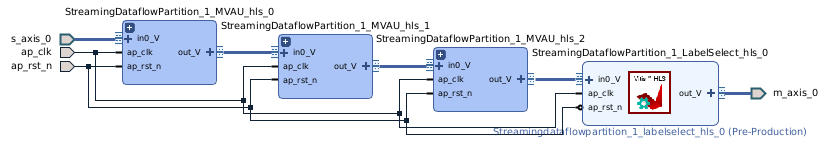

In [40]:
# On remarque également que notre modèle demande 8bits par 8bits
# ce qui veut dire qu'une image en tière se charge en 28*28*8/8 = 784 cycles
# avec 20ns par cycle = 15 680 ns / images soit 63 000 images /sec
# (en théorie.)

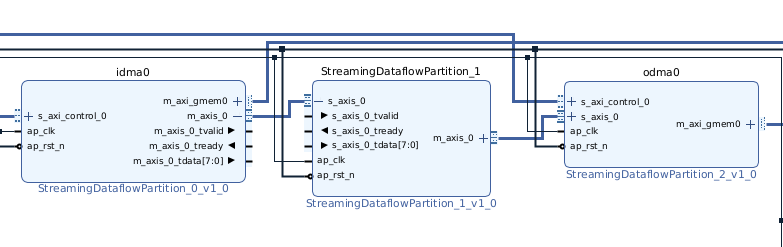  